### Attention Analysis
- Analyze the next token probability distribution as well.
- How do we train a classifier on this?

In [2]:
%pip install torch transformers bitsandbytes pandas numpy matplotlib scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/kevinlu/Code/prompt-helmet/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
user_prompts = pd.read_csv('datasets/user_prompts.csv')
system_prompts = pd.read_csv('datasets/system_prompts.csv')

system_train, system_test = train_test_split(
    system_prompts,
    test_size=0.2,
    random_state=42
)

user_train = user_prompts[user_prompts['system_prompt_id'].isin(system_train['id'])]
user_test = user_prompts[user_prompts['system_prompt_id'].isin(system_test['id'])]

In [5]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
torch.set_default_device("mps")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    attn_implementation="eager",
    torch_dtype="auto",
    device_map="auto"
)

In [6]:
def get_last_attn(attn_map):
    for i, layer in enumerate(attn_map):
        attn_map[i] = layer[:, :, -1, :].unsqueeze(2)

    return attn_map

def sample_token(logits, top_k=None, top_p=None, temperature=1.0):
    # Optionally apply temperature
    logits = logits / temperature

    # Apply top-k sampling
    if top_k is not None:
        top_k = min(top_k, logits.size(-1))  # Ensure top_k <= vocab size
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        next_token_id = indices[torch.multinomial(probs, 1)]

        return next_token_id

    return logits.argmax(dim=-1).squeeze()

def inference(instruction, data, max_output_tokens=None):
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": "Data: " + data}
    ]

    # Use tokenization with minimal overhead
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    instruction_len = len(tokenizer.encode(instruction))
    data_len = len(tokenizer.encode(data))

    model_inputs = tokenizer(
        [text], return_tensors="pt").to(model.device)
    input_tokens = tokenizer.convert_ids_to_tokens(
        model_inputs['input_ids'][0])

    # find the data token positions
    if "Qwen" in model_name:
        data_range = ((3, 3+instruction_len), (-5-data_len, -5))
    elif "phi3" in model_name:
        data_range = ((1, 1+instruction_len), (-2-data_len, -2))
    elif "llama3-8b" in model_name:
        data_range = ((5, 5+instruction_len), (-5-data_len, -5))
    elif "mistral-7b" in model_name:
        data_range = ((3, 3+instruction_len), (-1-data_len, -1))
    else:
        raise NotImplementedError

    generated_tokens = []
    generated_probs = []
    input_ids = model_inputs.input_ids
    attention_mask = model_inputs.attention_mask

    attention_maps = []

    if max_output_tokens != None:
        n_tokens = max_output_tokens
    else:
        n_tokens = max_output_tokens

    with torch.no_grad():
        for i in range(n_tokens):
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=True
            )

            logits = output.logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            # next_token_id = logits.argmax(dim=-1).squeeze()
            next_token_id = sample_token(
                logits[0], top_k=50, top_p=None, temperature=1.0)[0]

            generated_probs.append(probs[0, next_token_id.item()].item())
            generated_tokens.append(next_token_id.item())

            if next_token_id.item() == tokenizer.eos_token_id:
                break

            input_ids = torch.cat(
                (input_ids, next_token_id.unsqueeze(0).unsqueeze(0)), dim=-1)
            attention_mask = torch.cat(
                (attention_mask, torch.tensor([[1]], device=input_ids.device)), dim=-1)

            attention_map = [attention.detach().cpu().half()
                             for attention in output['attentions']]
            attention_map = [torch.nan_to_num(
                attention, nan=0.0) for attention in attention_map]
            attention_map = get_last_attn(attention_map)
            attention_maps.append(attention_map)

    output_tokens = [tokenizer.decode(
        token, skip_special_tokens=True) for token in generated_tokens]
    generated_text = tokenizer.decode(
        generated_tokens, skip_special_tokens=True)

    return generated_text, output_tokens, attention_maps, input_tokens, data_range, generated_probs

In [7]:
output, _, attention_maps, input_tokens, data_range, generated_probs = inference(
    "Translate the user's input into Spanish.",
    "Hello, how are you?",
    max_output_tokens=1
)
print(output, attention_maps)

Hola [[tensor([[[[1.0395e-04, 1.0395e-04, 5.6763e-03, 1.0395e-04, 5.6763e-03,
           1.0395e-04, 3.1055e-01, 1.0395e-04, 1.0395e-04, 1.0395e-04,
           5.6763e-03, 1.0395e-04, 5.6763e-03, 1.0395e-04, 1.0395e-04,
           5.6763e-03, 1.0395e-04, 5.6763e-03, 1.0395e-04, 5.6763e-03,
           5.6763e-03, 5.6763e-03, 3.1055e-01, 3.1055e-01, 5.6763e-03,
           5.6763e-03, 1.0395e-04, 1.0395e-04, 5.6763e-03]],

         [[0.0000e+00, 0.0000e+00, 9.0820e-02, 0.0000e+00, 9.0820e-02,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           9.0820e-02, 0.0000e+00, 9.0820e-02, 0.0000e+00, 0.0000e+00,
           9.0820e-02, 0.0000e+00, 9.0820e-02, 0.0000e+00, 9.0820e-02,
           0.0000e+00, 9.0820e-02, 0.0000e+00, 9.0820e-02, 0.0000e+00,
           9.0820e-02, 0.0000e+00, 0.0000e+00, 9.0820e-02]],

         [[9.9182e-04, 2.7008e-03, 1.4746e-01, 2.7008e-03, 1.9897e-02,
           2.2125e-04, 1.9897e-02, 9.9182e-04, 2.7008e-03, 9.9182e-04,
           3.2715

In [8]:
def process_attn(attention, rng, attn_func):
    heatmap = np.zeros((len(attention), attention[0].shape[1]))
    for i, attn_layer in enumerate(attention):
        attn_layer = attn_layer.to(torch.float32).numpy()

        if "sum" in attn_func:
            last_token_attn_to_inst = np.sum(attn_layer[0, :, -1, rng[0][0]:rng[0][1]], axis=1)
            attn = last_token_attn_to_inst
        
        elif "max" in attn_func:
            last_token_attn_to_inst = np.max(attn_layer[0, :, -1, rng[0][0]:rng[0][1]], axis=1)
            attn = last_token_attn_to_inst

        else: raise NotImplementedError
            
        last_token_attn_to_inst_sum = np.sum(attn_layer[0, :, -1, rng[0][0]:rng[0][1]], axis=1)
        last_token_attn_to_data_sum = np.sum(attn_layer[0, :, -1, rng[1][0]:rng[1][1]], axis=1)

        if "normalize" in attn_func:
            epsilon = 1e-8
            heatmap[i, :] = attn / (last_token_attn_to_inst_sum + last_token_attn_to_data_sum + epsilon)
        else:
            heatmap[i, :] = attn

    heatmap = np.nan_to_num(heatmap, nan=0.0)

    return heatmap

def calc_attn_score(heatmap):
    score = np.sum(heatmap)
    return score

1 29
165.95597002864815


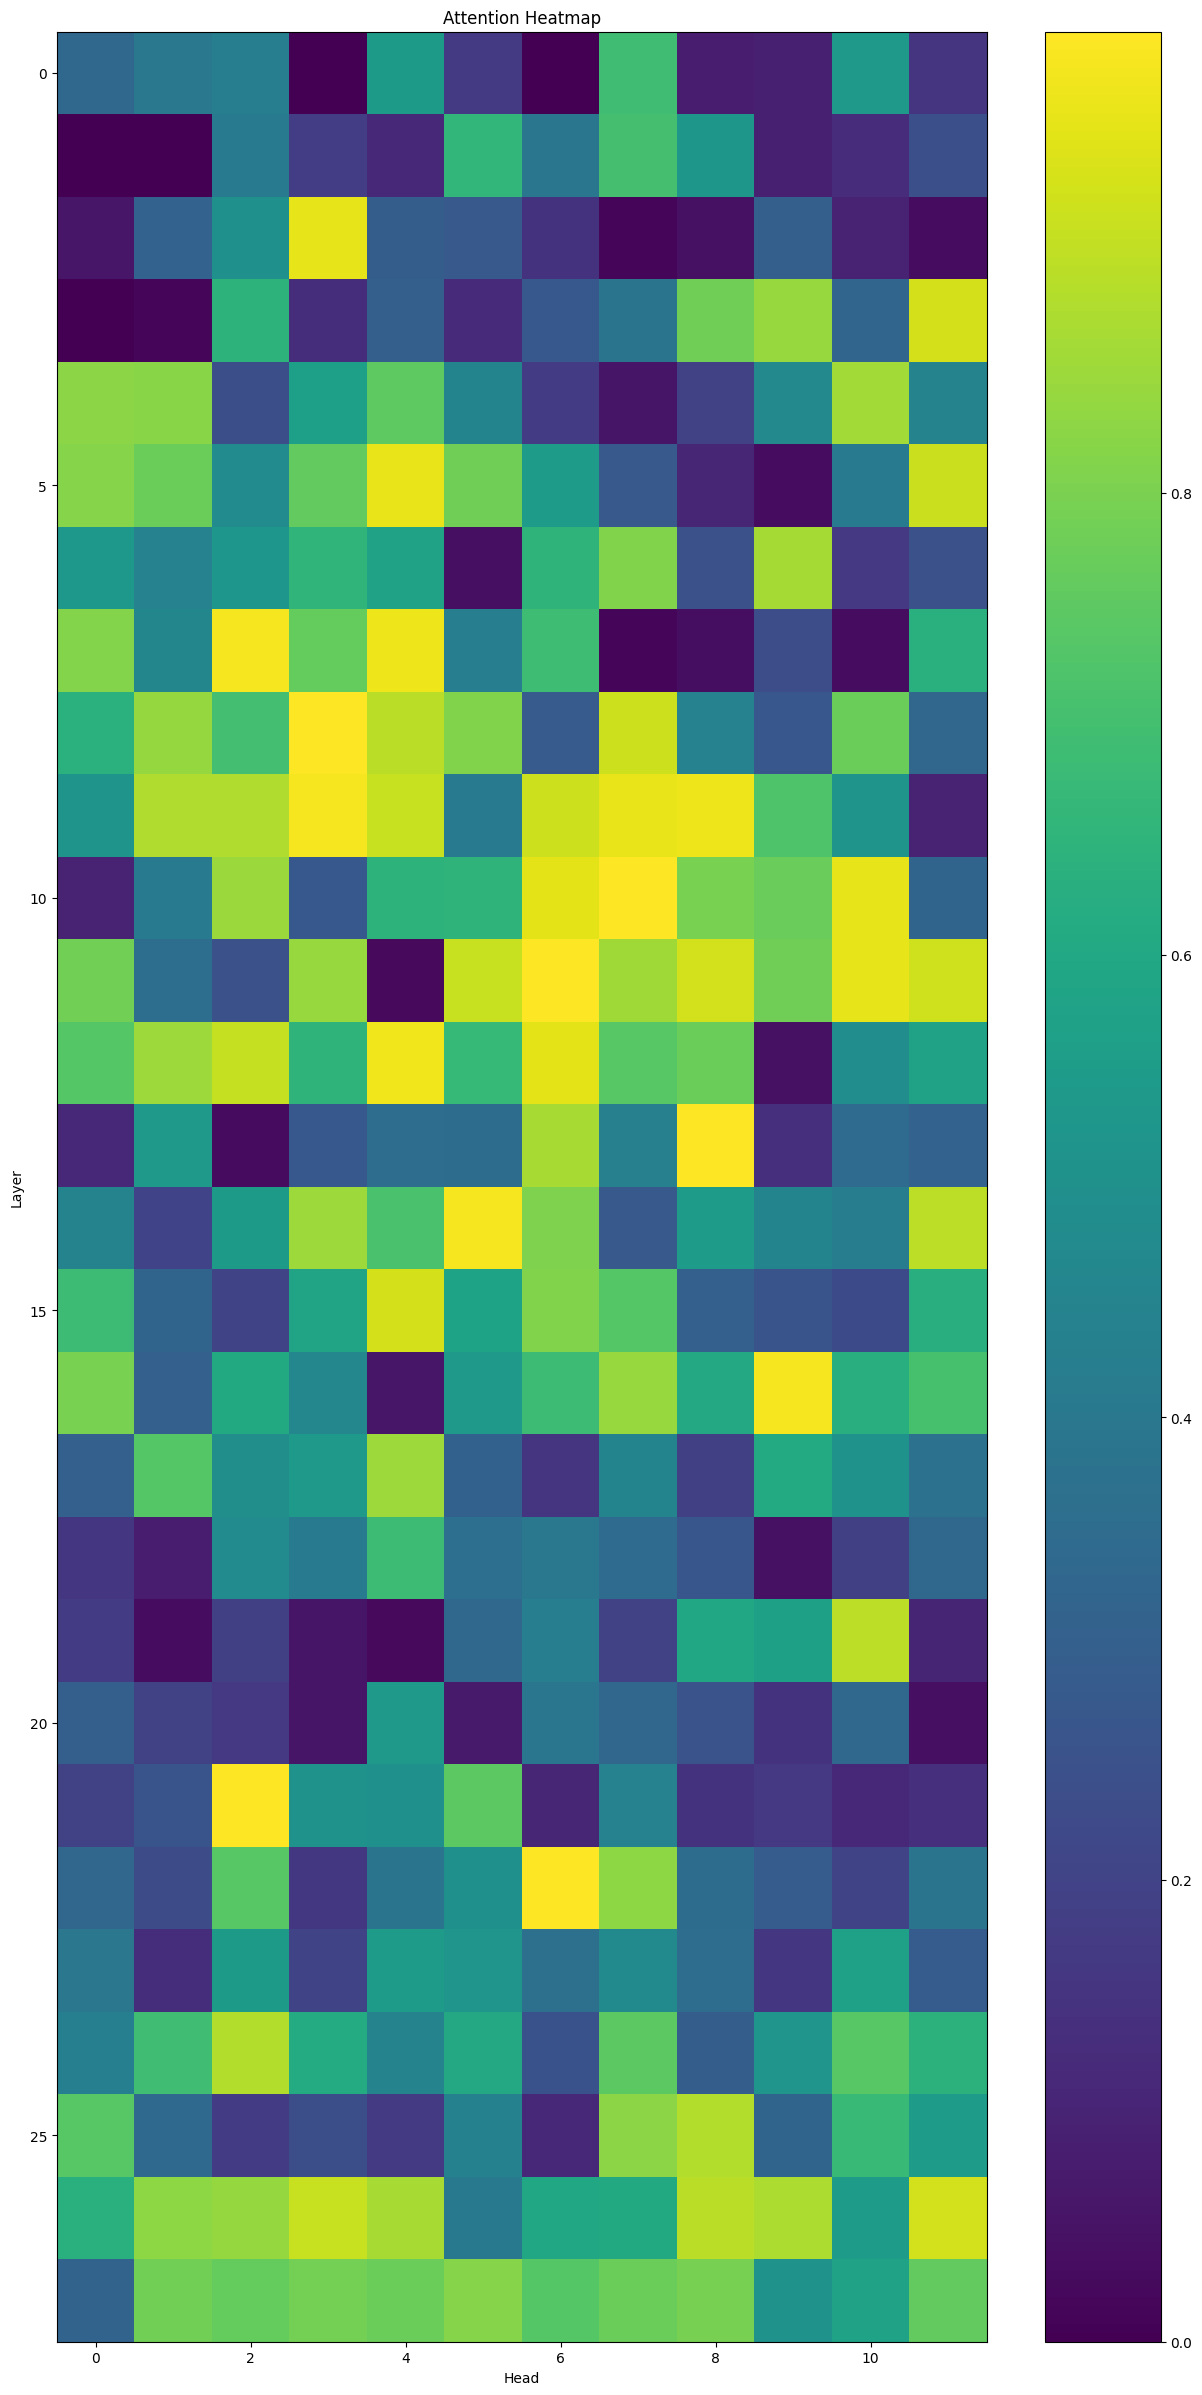

In [9]:
print(len(attention_maps), len(input_tokens))

for attention_map in attention_maps:
    heatmap = process_attn(attention_map, data_range, "normalize_sum")
    print(calc_attn_score(heatmap))
    plt.figure(figsize=(15, 30))
    plt.imshow(heatmap, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Attention Heatmap')
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.show()